In [2]:
from tensorflow.keras.models import Sequential ,load_model
from tensorflow.keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import os
import cv2
import kagglehub

In [3]:
path = kagglehub.dataset_download("nareshlankalapalli/paddy-disease")

In [4]:
import os
import shutil

# Step 1: Copy test folder to working directory
src = '/kaggle/input/paddy-disease/rice_disease_data/test'
dst = '/kaggle/working/test_fixed1'

# Copy directory tree
shutil.copytree(src, dst)

# Step 2: Rename inside working directory
rename_map = {
    'Neck_Blast': 'neck_blast',
    'Rice Hispa': 'rice_hispa',
    'Sheath Blight': 'sheath_blight',
    'Tungro': 'tungro'
}

for old_name, new_name in rename_map.items():
    old_path = os.path.join(dst, old_name)
    new_path = os.path.join(dst, new_name)
    if os.path.exists(old_path):
        os.rename(old_path, new_path)
        print(f"Renamed: {old_name} ➝ {new_name}")
    else:
        print(f"Folder not found: {old_name}")


Renamed: Neck_Blast ➝ neck_blast
Renamed: Rice Hispa ➝ rice_hispa
Renamed: Sheath Blight ➝ sheath_blight
Renamed: Tungro ➝ tungro


In [5]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image settings
img_size = 224  # or your preferred size
batch_size = 32
train_dir = '/kaggle/input/paddy-disease/rice_disease_data/train'
#test_dir = '/kaggle/input/paddy-disease/rice_disease_data/test'

# Create training and validation ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='training'  # Subset for training
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation'  # Subset for validation
)

# Testing generator
test_generator = test_datagen.flow_from_directory(
    '/kaggle/working/test_fixed1',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 11607 images belonging to 10 classes.
Found 2899 images belonging to 10 classes.
Found 3422 images belonging to 10 classes.


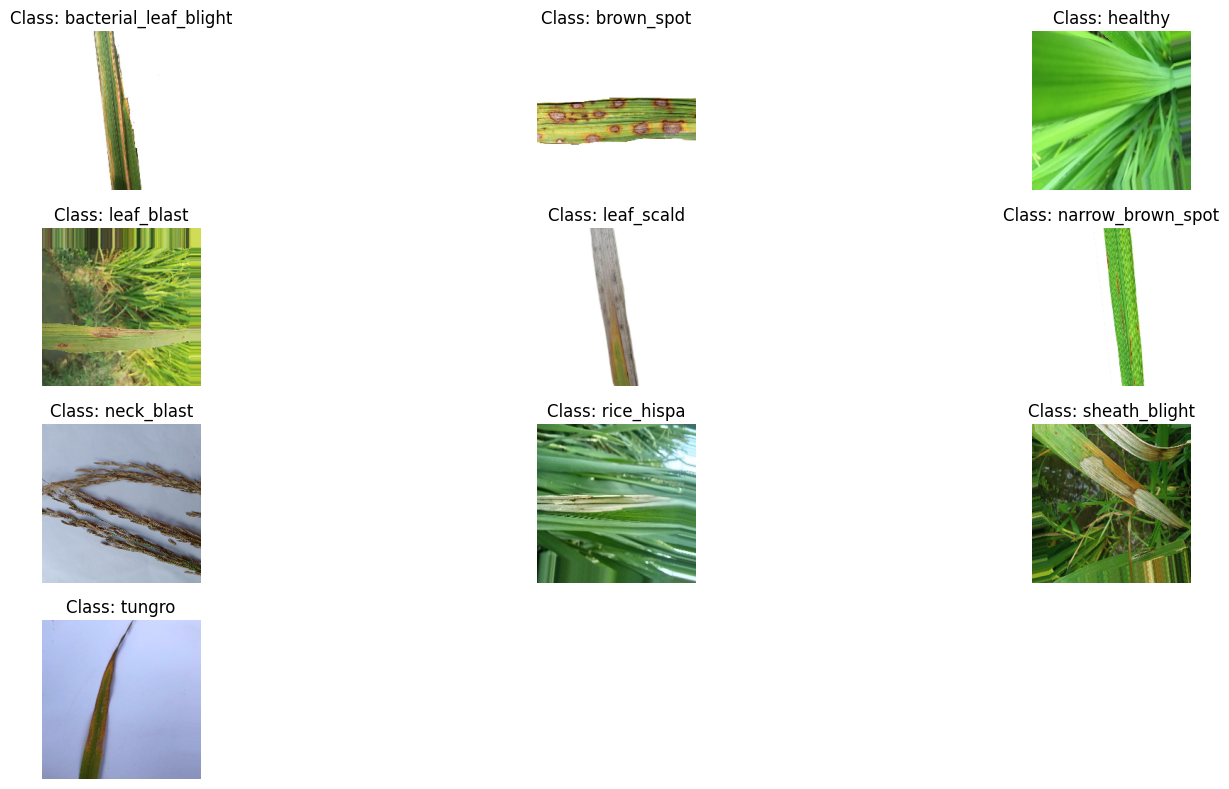

In [6]:
import random
# Automatically get class folder names
class_names= ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot', 'neck_blast', 'rice_hispa', 'sheath_blight', 'tungro']

# Plot one random image from each class folder
plt.figure(figsize=(15, 8))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

    if not image_files:
        print(f"No images found in {class_name}")
        continue

    # Randomly select one image
    selected_image = random.choice(image_files)
    img_path = os.path.join(class_path, selected_image)
    img = load_img(img_path, target_size=(img_size,img_size,3))

    plt.subplot(4, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [7]:
import os
import random
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from tqdm import tqdm
import shutil

# PARAMETERS
dataset_path = '/kaggle/working/test_fixed1'
target_size = 224
TARGET_IMAGES = 350

# Data augmenter
augmenter = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):
        continue

    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    current_count = len(image_files)

    print(f"\n🔍 Class '{class_name}': {current_count} images")

    # ----------- CASE 1: Downsample if more than needed -----------
    if current_count > TARGET_IMAGES:
        print(f"⚠️ Too many images. Downsampling to {TARGET_IMAGES}...")
        random.shuffle(image_files)
        keep_files = image_files[:TARGET_IMAGES]
        delete_files = set(image_files) - set(keep_files)

        for file_name in delete_files:
            try:
                os.remove(os.path.join(class_path, file_name))
            except Exception as e:
                print(f"Error deleting {file_name}: {e}")
        print(f"✅ Downsampled '{class_name}' to {TARGET_IMAGES} images.")

    # ----------- CASE 2: Augment if fewer than needed -----------
    elif current_count < TARGET_IMAGES:
        needed = TARGET_IMAGES - current_count
        print(f"🔄 Generating {needed} new images...")

        i = 0
        pbar = tqdm(total=needed, desc=f"Augmenting '{class_name}'")
        while i < needed:
            for img_name in image_files:
                img_path = os.path.join(class_path, img_name)
                try:
                    img = load_img(img_path, target_size=(target_size, target_size))
                    x = img_to_array(img)
                    x = np.expand_dims(x, axis=0)

                    aug_iter = augmenter.flow(x, batch_size=1)
                    aug_img = next(aug_iter)[0].astype(np.uint8)

                    save_name = f"aug_{i}_{img_name}"
                    save_path = os.path.join(class_path, save_name)
                    save_img(save_path, aug_img)

                    i += 1
                    pbar.update(1)

                    if i >= needed:
                        break
                except Exception as e:
                    print(f"Error processing {img_name}: {e}")
                    continue
        pbar.close()
        print(f"✅ Augmentation complete for class '{class_name}'.")

    # ----------- CASE 3: Already balanced -----------
    else:
        print("✅ Already has exactly 350 images. Skipping.")



🔍 Class 'narrow_brown_spot': 382 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'narrow_brown_spot' to 350 images.

🔍 Class 'healthy': 391 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'healthy' to 350 images.

🔍 Class 'bacterial_leaf_blight': 376 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'bacterial_leaf_blight' to 350 images.

🔍 Class 'sheath_blight': 288 images
🔄 Generating 62 new images...


Augmenting 'sheath_blight': 100%|██████████| 62/62 [00:01<00:00, 32.58it/s]


✅ Augmentation complete for class 'sheath_blight'.

🔍 Class 'leaf_blast': 362 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'leaf_blast' to 350 images.

🔍 Class 'leaf_scald': 386 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'leaf_scald' to 350 images.

🔍 Class 'rice_hispa': 225 images
🔄 Generating 125 new images...


Augmenting 'rice_hispa': 100%|██████████| 125/125 [00:03<00:00, 38.46it/s]


✅ Augmentation complete for class 'rice_hispa'.

🔍 Class 'brown_spot': 380 images
⚠️ Too many images. Downsampling to 350...
✅ Downsampled 'brown_spot' to 350 images.

🔍 Class 'neck_blast': 322 images
🔄 Generating 28 new images...


Augmenting 'neck_blast': 100%|██████████| 28/28 [00:01<00:00, 16.05it/s]


✅ Augmentation complete for class 'neck_blast'.

🔍 Class 'tungro': 310 images
🔄 Generating 40 new images...


Augmenting 'tungro': 100%|██████████| 40/40 [00:00<00:00, 66.77it/s]

✅ Augmentation complete for class 'tungro'.


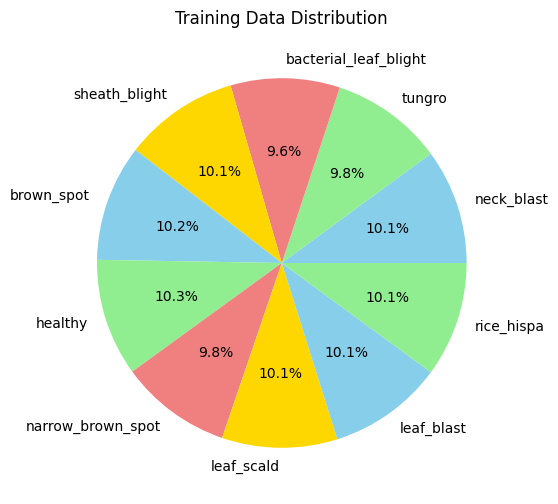

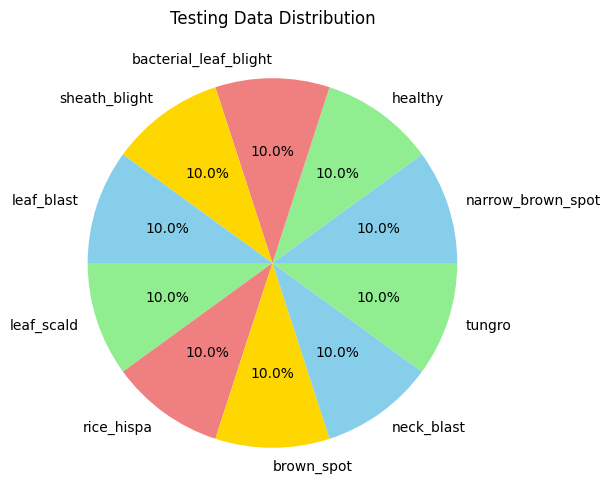

Training Data Counts:
neck_blast: 1461 images
tungro: 1428 images
bacterial_leaf_blight: 1386 images
sheath_blight: 1458 images
brown_spot: 1480 images
healthy: 1491 images
narrow_brown_spot: 1416 images
leaf_scald: 1465 images
leaf_blast: 1460 images
rice_hispa: 1461 images

Testing Data Counts:
narrow_brown_spot: 350 images
healthy: 350 images
bacterial_leaf_blight: 350 images
sheath_blight: 350 images
leaf_blast: 350 images
leaf_scald: 350 images
rice_hispa: 350 images
brown_spot: 350 images
neck_blast: 350 images
tungro: 350 images


In [8]:
# Function to count images in each class
def count_images(dataset_path):
    class_counts = {}
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if os.path.isdir(label_path):
            num_images = len(os.listdir(label_path))
            class_counts[label] = num_images
    return class_counts

# Count images in training and testing datasets
train_counts = count_images(train_dir)
test_counts = count_images('/kaggle/working/test_fixed1')

# Plot pie charts
def plot_pie_chart(class_counts, title):
    labels = list(class_counts.keys())
    sizes = list(class_counts.values())
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=0, colors=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    plt.title(title)
    plt.show()

# Plot for training data
plot_pie_chart(train_counts, "Training Data Distribution")

# Plot for testing data
plot_pie_chart(test_counts, "Testing Data Distribution")

# Print the number of images in each class
print("Training Data Counts:")
for label, count in train_counts.items():
    print(f"{label}: {count} images")

print("\nTesting Data Counts:")
for label, count in test_counts.items():
    print(f"{label}: {count} images")

In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [19]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,140,042 (80.64 MB)

 Trainable params: 6,425,354 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

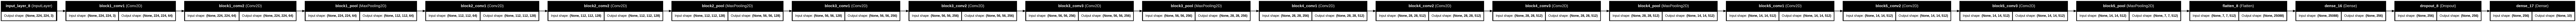

In [22]:


plot_model(model, to_file='/kaggle/working/paddy_leaf_cnn_model.png', show_shapes=True, show_layer_names=True, rankdir='LR')

# Display block diagram
try:
    display(Image(filename='/kaggle/working/paddy_leaf_cnn_model.png'))
except NameError: # Catch NameError if Image is not defined
    print("Model plot saved as 'paddy_leaf_cnn_model.png'")

In [26]:
# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [28]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    verbose=1
)


Epoch 1/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 205s 564ms/step - accuracy: 0.6946 - loss: 0.8391 - val_accuracy: 0.7986 - val_loss: 0.5828
Epoch 2/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 209s 577ms/step - accuracy: 0.7273 - loss: 0.7194 - val_accuracy: 0.8130 - val_loss: 0.5175
Epoch 3/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 206s 568ms/step - accuracy: 0.7578 - loss: 0.6283 - val_accuracy: 0.8382 - val_loss: 0.4570
Epoch 4/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 205s 565ms/step - accuracy: 0.7738 - loss: 0.5874 - val_accuracy: 0.8575 - val_loss: 0.4135
Epoch 5/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 203s 560ms/step - accuracy: 0.7953 - loss: 0.5336 - val_accuracy: 0.8531 - val_loss: 0.4179
Epoch 6/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 202s 557ms/step - accuracy: 0.7833 - loss: 0.5422 - val_accuracy: 0.8568 - val_loss: 0.3977
Epoch 7/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 211s 581ms/step - accuracy: 0.8101 - loss: 0.4818 - val_accuracy: 0.8606 - val_loss: 0.3952
Epoch 8/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 207s 572ms/step - accuracy: 0.8165 -

91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 443ms/step - accuracy: 0.9020 - loss: 0.3357
Test Accuracy: 89.86%


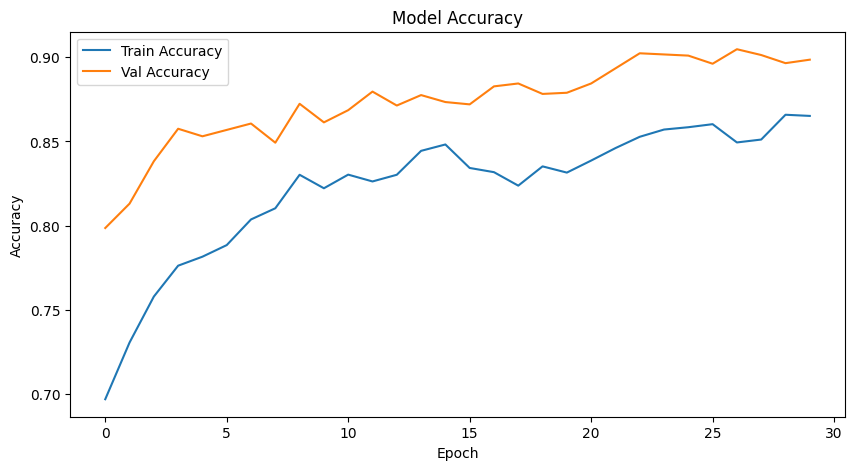

In [29]:
loss, acc = model.evaluate(validation_generator)
print(f"Test Accuracy: {acc * 100:.2f}%")

# Plot accuracy graph

plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()


In [32]:
model.save('/kaggle/working/paddy_leaf_cnn_model/trained _models/chilli_leaf_vgg16_model.h5')


Found 11607 images belonging to 10 classes.
Found 2899 images belonging to 10 classes.
91/91 ━━━━━━━━━━━━━━━━━━━━ 42s 454ms/step


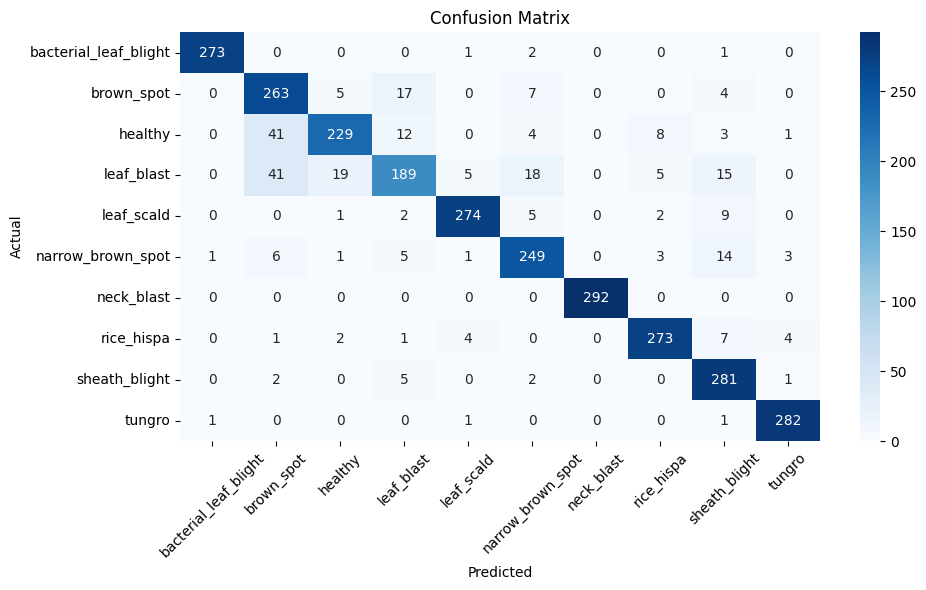


Classification Report:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.99      0.99      0.99       277
           brown_spot       0.74      0.89      0.81       296
              healthy       0.89      0.77      0.83       298
           leaf_blast       0.82      0.65      0.72       292
           leaf_scald       0.96      0.94      0.95       293
    narrow_brown_spot       0.87      0.88      0.87       283
           neck_blast       1.00      1.00      1.00       292
           rice_hispa       0.94      0.93      0.94       292
        sheath_blight       0.84      0.97      0.90       291
               tungro       0.97      0.99      0.98       285

             accuracy                           0.90      2899
            macro avg       0.90      0.90      0.90      2899
         weighted avg       0.90      0.90      0.90      2899



In [34]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Ensure validation_generator is not shuffled ---
# If not already done earlier, re-define it here with shuffle=False
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='training'  # Subset for training
)
# Validation generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation' ,
    shuffle=False
)

# --- Get true labels from validation set ---
Y_true = validation_generator.classes

# --- Predict class probabilities using the trained model ---
# Cast the result of np.ceil to an integer for the 'steps' argument
Y_pred_probs = model.predict(validation_generator, steps=int(np.ceil(validation_generator.samples / validation_generator.batch_size)))

# --- Get predicted class indices ---
Y_pred = np.argmax(Y_pred_probs, axis=1)

# --- Get class names ---
class_names = list(validation_generator.class_indices.keys())

# --- Generate the confusion matrix ---
cm = confusion_matrix(Y_true, Y_pred)

# --- Plot the confusion matrix ---
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Print classification report ---
print("\nClassification Report:")
print(classification_report(Y_true, Y_pred, target_names=class_names))

91/91 ━━━━━━━━━━━━━━━━━━━━ 40s 437ms/step - accuracy: 0.8888 - loss: 0.3693
Test Accuracy: 89.86%


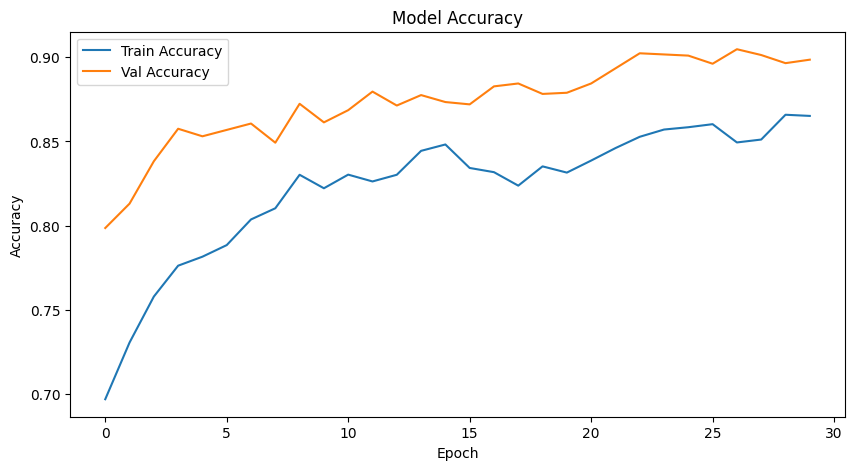

In [35]:
loss, acc = model.evaluate(validation_generator)
print(f"Test Accuracy: {acc * 100:.2f}%")

# Plot accuracy graph

plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()


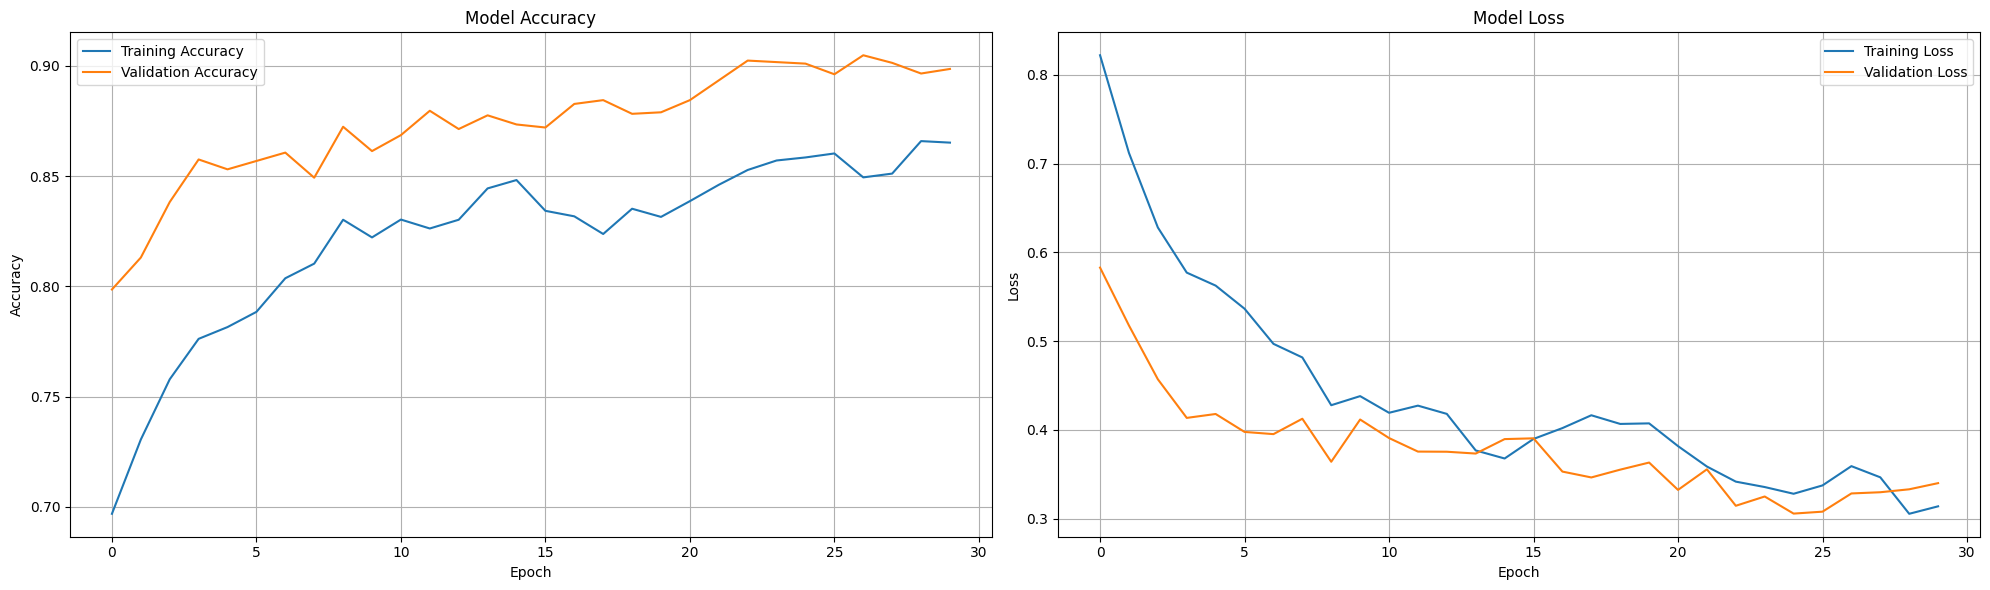

In [36]:
import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(20,6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
model.save('/kaggle/working/trained _models1/paddy_basic_cnn_leaf_vgg16_model.h5')


In [41]:
# Accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

# Loss
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print(f"Training Accuracy:   {train_acc * 100:.2f}%")
print(f"Training Loss:       {train_loss:.4f}")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Validation Loss:     {val_loss:.4f}")


Training Accuracy:   86.52%
Training Loss:       0.3139
Validation Accuracy: 89.86%
Validation Loss:     0.3400


In [42]:
correct = 0
total = 0

for i in range(len(test_generator)):
    try:
        x, y_true = test_generator[i]
        y_pred = model.predict(x)
        correct += np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))
        total += x.shape[0]
    except Exception as e:
        print(f"Skipping batch {i} due to error: {e}")

print(f"Test Accuracy: {(correct / total) * 100:.2f}%")


Skipping batch 0 due to error: [Errno 2] No such file or directory: '/kaggle/working/test_fixed1/bacterial_leaf_blight/BACTERIALBLIGHT2_169.jpg'
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Skipping batch 2 due to error: [Errno 2] No such file or directory: '/kaggle/working/test_fixed1/bacterial_leaf_blight/bacterial_leaf_blight (139).JPG'
Skipping batch 3 due to error: [Errno 2] No such file or directory: '/kaggle/working/test_fixed1/bacterial_leaf_blight/bacterial_leaf_blight (175).JPG'
Skipping batch 4 due to error: [Errno 2] No such file or directory: '/kaggle/working/test_fixed1/bacterial_leaf_blight/bacterial_leaf_blight (198).JPG'
Skipping batch 5 due to error: [Errno 2] No such file or directory: '/kaggle/working/test_fixed1/bacterial_leaf_blight/bacterial_leaf_blight (226).jpg'
Skipping batch 6 due to error: [Errno 2] No such file or directory: '/kaggle/working/test_fixed1/bacterial_leaf_blight/bacterial_leaf_blight (251).JPG'
Skipping batch 7 due to error: [Errno 2] No such file or